# The Problem

[Pandas](http://pandas.pydata.org) and [scikit-learn](http://scikit-learn.org/stable/) have largely overlapping, but different data models.
Both are based off NumPy arrays, but the extensions pandas has made to NumPy's type system have created a slight rift between the two. Most notably, pandas supports heterogenous data and has added several extension data-types on top of NumPy.

### 1. Homogeneity vs. Heterogeneity

NumPy `ndarray`s (and so scikit-learn feature matrices) are *homogeneous*, they must have a single dtype, regardless of the number of dimensions.
Pandas `DataFrame`s are potentially *heterogenous*, and can store columns of multiple dtypes within a single DataFrame.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

In [3]:
x = np.array([
    [10, 1.0],  # mix of integer and floats
    [20, 2.0],
    [30, 3.0],
    ])
x.dtype

dtype('float64')

In [4]:
df = pd.DataFrame([
    [10, 1.0],
    [20, 2.0],
    [30, 3.0]
])
df.dtypes

0      int64
1    float64
dtype: object

### 2. Extension Types

Pandas has implemented some *extension dtypes*: `Categoricals` and datetimes with timezones.
In statistics, categorical data refers to a variable that can take only a limited, fixed set of distince values (e.g. days of week).
These extension types cannot be expressed natively as NumPy arrays, and must go through some kind of (potentially lossy) conversion process.

In [5]:
s = pd.Series(pd.Categorical(['a', 'b', 'c', 'a'],
                             categories=['d', 'a', 'b', 'c'],
                             ordered=True))
s

0    a
1    b
2    c
3    a
dtype: category
Categories (4, object): [d < a < b < c]

Casting this to a NumPy array loses the categories and ordered information.

In [6]:
np.asarray(s)

array(['a', 'b', 'c', 'a'], dtype=object)

"Real-world" data is often complex and heterogeneous, making pandas the tool of choice.
However, tools like Scikit-Learn, which do not depend on pandas, can't use its
richer data structures.
We need a way of bridging the gap between pandas' DataFrames and the NumPy arrays appropriate for scikit-learn.
Fortunately the tools are all there to make this conversion smooth.

# The Data

For our example we'll work with a simple dataset on tips:

In [7]:
df = pd.read_csv("tips.csv")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null object
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.4+ KB


Our target variable is the tip amount. The remainder of the columns make up our features.

In [9]:
y = df['tip']
X = df.drop('tip', axis=1)

Notice the feature matrix is a mixture of numeric and categorical (in the statistical sense) columns.

# The Stats

We'll use a linear regression to predict `tip`.
When you fit a linear regression, you end up having to solve an equation like

$$
\hat{\boldsymbol{\beta}} = \left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1} \boldsymbol{X}^T \boldsymbol{y}
$$

where

- $\hat{\boldsymbol{\beta}}$ is our estimate for the vector of coefficients describing the best-fit line
- $\boldsymbol{X}$ is the feature matrix
- $\boldsymbol{y}$ is the target array (tip amount)

There's no need to worry about that equation; it likely won't make sense unless you've seen it before.
The only point I want to emphasize is that finding the optimal set of coefficients requires doing a matrix multiplication.
This means we (or our library) needs to somehow convert our *categorical* data (`sex`, `smoker`, `day`, and `time`) into numeric data.
The next two sections offer some possible ways of doing that conversion.

# Factorize

One option [often suggested](http://stackoverflow.com/q/25530504/1889400) is to *factorize* the non-numeric columns.
Factorization maps each distinct field to numeric codes.

In [10]:
codes, labels = pd.factorize(df['day'])
print('Codes:  ', codes[::10], end='\n\n')
print('Labels: ', labels[codes[::10]])

Codes:   [0 0 1 1 1 0 1 1 2 3 3 1 2 2 2 0 0 1 0 0 2 1 3 1 1]

Labels:  Index(['Sun', 'Sun', 'Sat', 'Sat', 'Sat', 'Sun', 'Sat', 'Sat', 'Thur', 'Fri',
       'Fri', 'Sat', 'Thur', 'Thur', 'Thur', 'Sun', 'Sun', 'Sat', 'Sun', 'Sun',
       'Thur', 'Sat', 'Fri', 'Sat', 'Sat'],
      dtype='object')


So every occurance of `'Sun'` becomes `0`, each `'Sat'` becomes `1`, and so on.

We could assign the factorized values into a new DataFrame:

In [11]:
cat_cols = ['sex', 'smoker', 'day', 'time']

X_factorized = X.copy()
X_factorized[cat_cols] = X_factorized[cat_cols].apply(
    lambda x: pd.factorize(x)[0]
)
X_factorized.head()

,total_bill,sex,smoker,day,time,size
0,16.99,0,0,0,0,2
1,10.34,1,0,0,0,3
2,21.01,1,0,0,0,3
3,23.68,1,0,0,0,2
4,24.59,0,0,0,0,4


And fit the regression:

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lm = LinearRegression()
lm.fit(X_factorized, y)

/Users/tom.augspurger/Envs/mtg/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
pd.Series(lm.coef_, X_factorized.columns)

total_bill    0.094076
sex          -0.029216
smoker       -0.081041
day          -0.007834
time          0.005721
size          0.179367
dtype: float64

We successfully fit the model.
However, there are several problems with this approach.

First, ordering of the unique values *before* factorization becomes important.
If we wanted to predict for a related dataset using the same model, we would need
to ensure that the original values get factorized to the same numerical values.
If the order differed, say `sex='male'` came first instead of `sex='female'`, values for `'male'` would be factorized to `0` instead of `1`, and our predictions would be incorrect.
We would like for our data container to store the relationship between category and numeric code for us.

Second it asserts that the difference between any two "adjacent" categories is the same.
In our linear model, this implies that the change in $tip$ with respect to a jump from `'Sunday'` to `'Saturday'` has the same effect as a jump from `'Saturday'` to `'Thursday'`.

$$
\frac{
  \Delta{\text{tip}}
}{
  \Delta({\text{Sun.} \rightarrow \text{Sat.}})
} = \frac{
  \Delta{\text{tip}}
}{
  \Delta({\text{Sat.} \rightarrow \text{Thur.}})
}
$$

We can plot what this looks like:

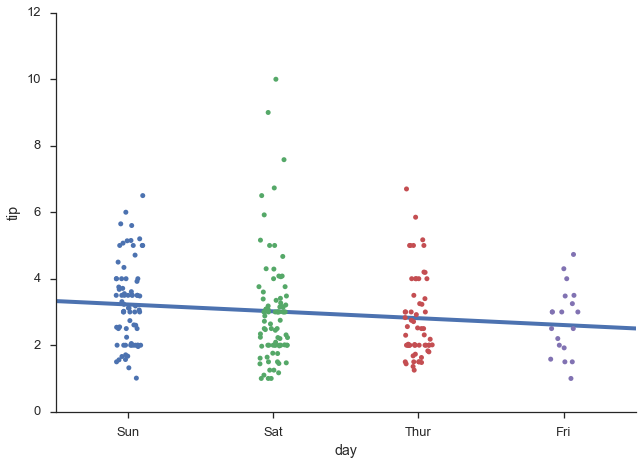

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', context='talk')

# Fit just "tip ~ day", to make plotting easier
lm = LinearRegression()
lm.fit(X_factorized[['day']], y)
b0, b1 = lm.intercept_, lm.coef_.ravel()[0]

ax = sns.stripplot('day', 'tip', data=df, jitter=1)
xlim = ax.get_xlim()
xx = np.linspace(*xlim, 2)
ax.plot(xx, [3.2245 + b1 * xx[0], b0 + b1 * xx[1]], lw=4)
sns.despine()

This may not be true in practice, and our data representation should not force our model to assume it.
Better to let the model *discover* that relationship, if it actually happens to be there.

# Dummy Encoding

There's a better approach, dummy encoding.
This expands each categorical column to *multiple* columns, one per distinct value.
The values in these new dummy-encoded columns are either 1, indicating the presence of that value in that observation, or 0.
Versions of this are implemented in both scikit-learn and pandas.

In [16]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
enc.fit_transform(df['day'])

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0,

So the `day` column has expanded to four, one for each unique value.

In [17]:
df.day.unique()

array(['Sun', 'Sat', 'Thur', 'Fri'], dtype=object)

I recommend the pandas version, `get_dummies`. It offers a few conveniences:

- Operates on multiple columns at once
- Passes through numeric columns unchanged
- Preserves row and column labels
- Provides a `drop_first` keyword for dropping a level per column. You might want this to avoid [perfect multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) if you have an intercept

In [18]:
X_dummy = pd.get_dummies(X)

lm = LinearRegression()
lm.fit(X_dummy, y)

pd.Series(lm.coef_, index=X_dummy.columns)

total_bill     0.094487
size           0.175992
sex_Female     0.016220
sex_Male      -0.016220
smoker_No      0.043204
                 ...   
day_Sat       -0.044159
day_Sun        0.051819
day_Thur      -0.084960
time_Dinner   -0.034064
time_Lunch     0.034064
dtype: float64

This version solves both of our issues with `factorize`.

1. The ordering of rows doesn't matter anymore because the dummy-columns are computed on the sorted version of the categories
2. "adjacent" categories each have their own parameter, so they're free to have their own effect

# Refinements

Our last approach worked, but there's still room for improvement.

1. We can't easily go from dummies back to categoricals
2. Doesn't integrate with scikit-learn `Pipeline` objects.
3. If working with a larger dataset and `partial_fit`, codes could be missing from subsets of the data.
4. Memory inefficient if there are many records relative to distinct categories

To solve these, we'll store additonal information in the *type* of the column and write a [Transformer](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) to handle the conversion to and from dummies.

## Pandas `Categorical` dtype

Pandas provides a `Categorical` dtype, which stores

- All the possible values the column can take
- Whether there is an ordering on the categories
- A relationship between each distinct categorical value and an integer code

Let's convert the categorical columns to `Categorical` dtype.
With `.astype('category')` we're just using the defaults of

- The set of categories is just the set present in the column
- There is no ordering

In [19]:
columns = ['sex', 'smoker', 'day', 'time']
X[columns] = X[columns].apply(lambda x: x.astype('category'))
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 6 columns):
total_bill    244 non-null float64
sex           244 non-null category
smoker        244 non-null category
day           244 non-null category
time          244 non-null category
size          244 non-null int64
dtypes: category(4), float64(1), int64(1)
memory usage: 4.9 KB


In [20]:
lm = LinearRegression().fit(pd.get_dummies(X), y)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
from sklearn.base import TransformerMixin

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 6 columns):
total_bill    244 non-null float64
sex           244 non-null category
smoker        244 non-null category
day           244 non-null category
time          244 non-null category
size          244 non-null int64
dtypes: category(4), float64(1), int64(1)
memory usage: 4.9 KB


## Goals

1. Convince you that writing your own transformers isn't impossibly hard
2. Concrete example of going from pandas to NumPy and back again

In [27]:
X.select_dtypes(include=['category']).columns

Index(['sex', 'smoker', 'day', 'time'], dtype='object')

In [38]:
X.day.cat

In [46]:
X.sex.cat.categories

Index(['Female', 'Male'], dtype='object')

In [58]:
class DummyEncoder(TransformerMixin):
    
    def fit(self, X, y=None):
        # record info here, use in transform, inv_transform.
        self.columns_ = X.columns
        self.cat_cols_ = X.select_dtypes(include=['category']).columns
        self.non_cat_cols_ = X.columns.drop(self.cat_cols_)
        
        self.cat_map_ = {col: X[col].cat for col in self.cat_cols_}
        left = len(self.non_cat_cols_) # 2
        self.cat_blocks_ = {}

        for col in self.cat_cols_:
            right = left + len(X[col].cat.categories)
            self.cat_blocks_[col] = slice(left, right)
            left = right
        return self
    
    def transform(self, X, y=None):
        return np.asarray(pd.get_dummies(X))
    
    def inverse_transform(self, trn, y=None):
        # Numpy to Pandas DataFrame
        # original column names <=> positions
        numeric = pd.DataFrame(trn[:, :len(self.non_cat_cols_)],
                               columns=self.non_cat_cols_)
        series = []
        for col, slice_ in self.cat_blocks_.items():
            codes = trn[:, slice_].argmax(1)
            cat = pd.Categorical.from_codes(codes,
                                            self.cat_map_[col].categories,
                                            ordered=self.cat_map_[col].ordered)
            series.append(pd.Series(cat, name=col))
        return pd.concat([numeric] + series, axis=1)[self.columns_]

                    
    
de = DummyEncoder()
trn = de.fit_transform(X)
trn

array([[ 16.99,   2.  ,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [ 10.34,   3.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 21.01,   3.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       ..., 
       [ 22.67,   2.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 17.82,   2.  ,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [ 18.78,   2.  ,   1.  , ...,   1.  ,   1.  ,   0.  ]])

In [62]:
de.inverse_transform(trn)

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2.0
1,10.34,Male,No,Sun,Dinner,3.0
2,21.01,Male,No,Sun,Dinner,3.0
3,23.68,Male,No,Sun,Dinner,2.0
4,24.59,Female,No,Sun,Dinner,4.0
...,...,...,...,...,...,...
239,29.03,Male,No,Sat,Dinner,3.0
240,27.18,Female,Yes,Sat,Dinner,2.0
241,22.67,Male,Yes,Sat,Dinner,2.0
242,17.82,Male,No,Sat,Dinner,2.0
